# Learning Molecular Representation using Graph Neural Network - Training Molecular Graph

> Taking a look at how graph neural network operate for molecular representations

- toc: true 
- badges: true
- comments: true
- categories: [rdkit, machine learning, graph neural network]

# Motivation

In the [previous post](https://sunhwan.github.io/blog/2021/02/20/Learning-Molecular-Representation-Using-Graph-Neural-Network-Molecular-Graph.html), I have looked into how a molecular graph is constructed and message can be passed around in a MPNN architecture. In this post, I'll take a look at how the graph neural net can be trained. The details of message passing update will vary by implementation; here we choose what was used in this [paper](http://dx.doi.org/10.1021/acs.jcim.9b00237).

Again, many code examples were taken from [chemprop](https://github.com/chemprop/chemprop) repository. The code was initially taken from the chemprop repository and I edited them for the sake of simplicity.

# Recap

![feature](files/molecular_graph_features.png)

Let's briefly recap how the molecular graph is constructed and messages are passed around. As shown in the above figure, each atom and bonds are labeled as $x$ and $e$. Here we are discussing D-MPNN, which represents the graph with a directional edges, which means, for each bond between two atoms $v$ and $w$, there are two directional bond, $e_{vw}$ and $e_{wv}$. 

The initial hidden message is constructed as $h_{vw}^0 = \tau (W_i \mathrm{cat}(x_v, e_{vw}))$ where $W_i$ is a learned matrix and $\tau$ is an activation function. 

![message](files/molecular_graph_message.png)

Above figure shows two messages, $m_{57}$ and $m_{54}$, are constructed. First, the message from atom $v$ to $w$ is the sum of all the hidden state for the incoming bonds to $v$ (excluding the one originating from $w$). Then the learned matrix $W_m$ is multiplied to the message and the initial hidden message is added to form the new hidden message for the depth 1. This is repeated several times for the message to be passed around to multiple depth. 

After the messages are passed up to the given number of depth, the hidden states are summed to be a final message per each atom (all incoming hidden state) and the hidden state for each atom is computed as follows:


$$m_v = \sum_{k \in N(v)} h_{kv}^t$$

$$h_v = \tau(W_a \mathrm{cat} (x_v, m_v))$$

Finally, the readout phase uses the sum of all $h_v$ to obtain the feature vector of the molecule and property prediction is carried out using a fully-connected feed forward network.

# Train Data

As an example, I'll use Enamine Real's diversity discovery set composed of 10240 compounds. This dataset contains some molecular properties, such as ClogP and TPSA, so we should be able to train a GCNN that predicts those properties.

For this example, let's train using ClogP values.

In [19]:
#collapse-hide
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from io import BytesIO
import pandas as pd
import numpy as np
from IPython.display import SVG

# RDKit 
import rdkit
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults

DrawingOptions.bondLineWidth=1.8
IPythonConsole.ipython_useSVG=True
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
print(rdkit.__version__)

# pytorch
import torch
from torch.utils.data import DataLoader, Dataset, Sampler
from torch import nn

# misc
from typing import Dict, Iterator, List, Optional, Union, OrderedDict, Tuple
from tqdm.notebook import tqdm
from functools import reduce

2020.03.2


In [2]:
#collapse-hide
# we will define a class which holds various parameter for D-MPNN
class TrainArgs:
    smiles_column = None
    no_cuda = False
    gpu = None
    num_workers = 8
    batch_size = 50
    no_cache_mol = False
    dataset_type = 'regression'
    task_names = []
    seed = 0
    hidden_size = 300
    bias = False
    depth = 3
    dropout = 0.0
    undirected = False
    aggregation = 'mean'
    aggregation_norm = 100
    ffn_num_layers = 2
    ffn_hidden_size = 300
    init_lr = 1e-4
    max_lr = 1e-3
    final_lr = 1e-4
    num_lrs = 1
    warmup_epochs = 2.0
    epochs = 30

    @property
    def device(self) -> torch.device:
        """The :code:`torch.device` on which to load and process data and models."""
        if not self.cuda:
            return torch.device('cpu')

        return torch.device('cuda', self.gpu)

    @device.setter
    def device(self, device: torch.device) -> None:
        self.cuda = device.type == 'cuda'
        self.gpu = device.index

    @property
    def cuda(self) -> bool:
        """Whether to use CUDA (i.e., GPUs) or not."""
        return not self.no_cuda and torch.cuda.is_available()

    @cuda.setter
    def cuda(self, cuda: bool) -> None:
        self.no_cuda = not cuda

In [3]:
args = TrainArgs()
args.data_path = 'files/enamine_discovery_diversity_set_10240.csv'
args.target_column = 'ClogP'
args.smiles_column = 'SMILES'
args.dataset_type = 'regression'
args.task_names = [args.target_column]
args.num_tasks = 1

In [4]:
df = pd.read_csv(args.data_path)
df.head()

,Name,SMILES,Catalog ID,PlateID,Well,MW (desalted),ClogP,HBD,TPSA,RotBonds
0,NaN,CN(C(=O)NC1CCOc2ccccc21)C(c1ccccc1)c1ccccn1,Z447596076,1186474-R-001,A02,373.448,2.419,1,54.46,4
1,NaN,Cn1cc(C(=O)N2CCC(OC3CCOC3)CC2)c(C2CC2)n1,Z2180753156,1186474-R-001,A03,319.399,-0.570,0,56.59,4
2,NaN,CC(=O)N(C)C1CCN(C(=O)c2ccccc2-c2ccccc2C(=O)O)CC1,Z2295858832,1186474-R-001,A04,380.437,0.559,1,77.92,4
3,NaN,COCC1(CNc2cnccc2C#N)CCNCC1,Z2030994006,1186474-R-001,A05,260.335,0.902,2,69.97,5
4,NaN,CCCCOc1ccc(-c2nnc3n2CCCC3)cc1OC,Z273627850,1186474-R-001,A06,301.383,3.227,0,49.17,6


In [5]:
#collapse-hide

from random import Random

# Cache of graph featurizations
CACHE_GRAPH = True
SMILES_TO_GRAPH = {}

def cache_graph():
    return CACHE_GRAPH

def set_cache_graph(cache_graph):
    global CACHE_GRAPH
    CACHE_GRAPH = cache_graph

# Cache of RDKit molecules
CACHE_MOL = True
SMILES_TO_MOL: Dict[str, Chem.Mol] = {}

def cache_mol() -> bool:
    r"""Returns whether RDKit molecules will be cached."""
    return CACHE_MOL

def set_cache_mol(cache_mol: bool) -> None:
    r"""Sets whether RDKit molecules will be cached."""
    global CACHE_MOL
    CACHE_MOL = cache_mol
    
# Atom feature sizes
MAX_ATOMIC_NUM = 100
ATOM_FEATURES = {
    'atomic_num': list(range(MAX_ATOMIC_NUM)),
    'degree': [0, 1, 2, 3, 4, 5],
    'formal_charge': [-1, -2, 1, 2, 0],
    'chiral_tag': [0, 1, 2, 3],
    'num_Hs': [0, 1, 2, 3, 4],
    'hybridization': [
        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2
    ],
}

# Distance feature sizes
PATH_DISTANCE_BINS = list(range(10))
THREE_D_DISTANCE_MAX = 20
THREE_D_DISTANCE_STEP = 1
THREE_D_DISTANCE_BINS = list(range(0, THREE_D_DISTANCE_MAX + 1, THREE_D_DISTANCE_STEP))

# len(choices) + 1 to include room for uncommon values; + 2 at end for IsAromatic and mass
ATOM_FDIM = sum(len(choices) + 1 for choices in ATOM_FEATURES.values()) + 2
EXTRA_ATOM_FDIM = 0
BOND_FDIM = 14


def get_atom_fdim():
    """Gets the dimensionality of the atom feature vector."""
    return ATOM_FDIM + EXTRA_ATOM_FDIM

def get_bond_fdim(atom_messages=False):
    """Gets the dimensionality of the bond feature vector.
    """
    return BOND_FDIM + (not atom_messages) * get_atom_fdim()

def onek_encoding_unk(value: int, choices: List[int]):
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1

    return encoding

def atom_features(atom: Chem.rdchem.Atom, functional_groups: List[int] = None):
    """Builds a feature vector for an atom.
    """
    features = onek_encoding_unk(atom.GetAtomicNum() - 1, ATOM_FEATURES['atomic_num']) + \
               onek_encoding_unk(atom.GetTotalDegree(), ATOM_FEATURES['degree']) + \
               onek_encoding_unk(atom.GetFormalCharge(), ATOM_FEATURES['formal_charge']) + \
               onek_encoding_unk(int(atom.GetChiralTag()), ATOM_FEATURES['chiral_tag']) + \
               onek_encoding_unk(int(atom.GetTotalNumHs()), ATOM_FEATURES['num_Hs']) + \
               onek_encoding_unk(int(atom.GetHybridization()), ATOM_FEATURES['hybridization']) + \
               [1 if atom.GetIsAromatic() else 0] + \
               [atom.GetMass() * 0.01]  # scaled to about the same range as other features
    if functional_groups is not None:
        features += functional_groups
    return features

def bond_features(bond: Chem.rdchem.Bond):
    """Builds a feature vector for a bond.
    """
    if bond is None:
        fbond = [1] + [0] * (BOND_FDIM - 1)
    else:
        bt = bond.GetBondType()
        fbond = [
            0,  # bond is not None
            bt == Chem.rdchem.BondType.SINGLE,
            bt == Chem.rdchem.BondType.DOUBLE,
            bt == Chem.rdchem.BondType.TRIPLE,
            bt == Chem.rdchem.BondType.AROMATIC,
            (bond.GetIsConjugated() if bt is not None else 0),
            (bond.IsInRing() if bt is not None else 0)
        ]
        fbond += onek_encoding_unk(int(bond.GetStereo()), list(range(6)))
    return fbond
    
class MoleculeDatapoint:
    def __init__(self,
                 smiles: str,
                 targets: List[Optional[float]] = None,
                 row: OrderedDict = None):
        
        self.smiles = smiles
        self.targets = targets
        self.features = []
        self.row = row

    @property
    def mol(self) -> Chem.Mol:
        """Gets the corresponding list of RDKit molecules for the corresponding SMILES."""
        mol = SMILES_TO_MOL.get(self.smiles, Chem.MolFromSmiles(self.smiles))
        if cache_mol():
            SMILES_TO_MOL[self.smiles] = mol
        return mol

    def set_features(self, features: np.ndarray) -> None:
        """Sets the features of the molecule.
        """
        self.features = features

    def extend_features(self, features: np.ndarray) -> None:
        """Extends the features of the molecule.
        """
        self.features = np.append(self.features, features) if self.features is not None else features

    def num_tasks(self) -> int:
        """Returns the number of prediction tasks.
        """
        return len(self.targets)

    def set_targets(self, targets: List[Optional[float]]):
        """Sets the targets of a molecule.
        """
        self.targets = targets

    def reset_features_and_targets(self) -> None:
        """Resets the features and targets to their raw values."""
        self.features, self.targets = self.raw_features, self.raw_targets
        
        
class MoleculeDataset(Dataset):
    def __init__(self, data: List[MoleculeDatapoint]):
        self._data = data
        self._scaler = None
        self._batch_graph = None
        self._random = Random()

    def smiles(self) -> List[str]:
        return [d.smiles for d in self._data]

    def mols(self) -> List[Chem.Mol]:
        return [d.mol for d in self._data]

    def targets(self) -> List[List[Optional[float]]]:
        return [d.targets for d in self._data]

    def num_tasks(self) -> int:
        return self._data[0].num_tasks() if len(self._data) > 0 else None

    def set_targets(self, targets: List[List[Optional[float]]]) -> None:
        assert len(self._data) == len(targets)
        for i in range(len(self._data)):
            self._data[i].set_targets(targets[i])

    def reset_features_and_targets(self) -> None:
        for d in self._data:
            d.reset_features_and_targets()

    def __len__(self) -> int:
        return len(self._data)

    def __getitem__(self, item) -> Union[MoleculeDatapoint, List[MoleculeDatapoint]]:
        return self._data[item]
    
    def batch_graph(self):
        if self._batch_graph is None:
            self._batch_graph = []

            mol_graphs = []
            for d in self._data:
                mol_graphs_list = []
                if d.smiles in SMILES_TO_GRAPH:
                    mol_graph = SMILES_TO_GRAPH[d.smiles]
                else:
                    mol_graph = MolGraph(d.mol)
                    if cache_graph():
                        SMILES_TO_GRAPH[d.smiles] = mol_graph
                mol_graphs.append([mol_graph])

            self._batch_graph = [BatchMolGraph([g[i] for g in mol_graphs]) for i in range(len(mol_graphs[0]))]

        return self._batch_graph
    
    def features(self) -> List[np.ndarray]:
        """
        Returns the features associated with each molecule (if they exist).

        :return: A list of 1D numpy arrays containing the features for each molecule or None if there are no features.
        """
        if len(self._data) == 0 or self._data[0].features is None:
            return None

        return [d.features for d in self._data]
    

def index_select_ND(source: torch.Tensor, index: torch.Tensor) -> torch.Tensor:
    """Selects the message features from source corresponding to the atom or bond indices in index.
    """
    index_size = index.size()             # (num_atoms/num_bonds, max_num_bonds)
    suffix_dim = source.size()[1:]        # (hidden_size,)
    final_size = index_size + suffix_dim  # (num_atoms/num_bonds, max_num_bonds, hidden_size)

    target = source.index_select(dim=0, index=index.view(-1)) # (num_atoms/num_bonds * max_num_bonds, hidden_size)
    target = target.view(final_size)                          # (num_atoms/num_bonds, max_num_bonds, hidden_size)
    return target

class MolGraph:
    def __init__(self, mol, atom_descriptors=None):
        # Convert SMILES to RDKit molecule if necessary
        if type(mol) == str:
            mol = Chem.MolFromSmiles(mol)

        self.n_atoms = 0  # number of atoms
        self.n_bonds = 0  # number of bonds
        self.f_atoms = []  # mapping from atom index to atom features
        self.f_bonds = []  # mapping from bond index to concat(in_atom, bond) features
        self.a2b = []  # mapping from atom index to incoming bond indices
        self.b2a = []  # mapping from bond index to the index of the atom the bond is coming from
        self.b2revb = []  # mapping from bond index to the index of the reverse bond

        # Get atom features
        self.f_atoms = [atom_features(atom) for atom in mol.GetAtoms()]
        if atom_descriptors is not None:
            self.f_atoms = [f_atoms + descs.tolist() for f_atoms, descs in zip(self.f_atoms, atom_descriptors)]

        self.n_atoms = len(self.f_atoms)

        # Initialize atom to bond mapping for each atom
        for _ in range(self.n_atoms):
            self.a2b.append([])

        # Get bond features
        for a1 in range(self.n_atoms):
            for a2 in range(a1 + 1, self.n_atoms):
                bond = mol.GetBondBetweenAtoms(a1, a2)

                if bond is None:
                    continue

                f_bond = bond_features(bond)
                self.f_bonds.append(self.f_atoms[a1] + f_bond)
                self.f_bonds.append(self.f_atoms[a2] + f_bond)

                # Update index mappings
                b1 = self.n_bonds
                b2 = b1 + 1
                self.a2b[a2].append(b1)  # b1 = a1 --> a2
                self.b2a.append(a1)
                self.a2b[a1].append(b2)  # b2 = a2 --> a1
                self.b2a.append(a2)
                self.b2revb.append(b2)
                self.b2revb.append(b1)
                self.n_bonds += 2


class BatchMolGraph:
    """A `BatchMolGraph` represents the graph structure and featurization of a batch of molecules.
    """

    def __init__(self, mol_graphs: List[MolGraph]):
        self.atom_fdim = get_atom_fdim()
        self.bond_fdim = get_bond_fdim()

        # Start n_atoms and n_bonds at 1 b/c zero padding
        self.n_atoms = 1  # number of atoms (start at 1 b/c need index 0 as padding)
        self.n_bonds = 1  # number of bonds (start at 1 b/c need index 0 as padding)
        self.a_scope = []  # list of tuples indicating (start_atom_index, num_atoms) for each molecule
        self.b_scope = []  # list of tuples indicating (start_bond_index, num_bonds) for each molecule

        # All start with zero padding so that indexing with zero padding returns zeros
        f_atoms = [[0] * self.atom_fdim]  # atom features
        f_bonds = [[0] * self.bond_fdim]  # combined atom/bond features
        a2b = [[]]  # mapping from atom index to incoming bond indices
        b2a = [0]  # mapping from bond index to the index of the atom the bond is coming from
        b2revb = [0]  # mapping from bond index to the index of the reverse bond
        for mol_graph in mol_graphs:
            f_atoms.extend(mol_graph.f_atoms)
            f_bonds.extend(mol_graph.f_bonds)

            for a in range(mol_graph.n_atoms):
                a2b.append([b + self.n_bonds for b in mol_graph.a2b[a]])

            for b in range(mol_graph.n_bonds):
                b2a.append(self.n_atoms + mol_graph.b2a[b])
                b2revb.append(self.n_bonds + mol_graph.b2revb[b])

            self.a_scope.append((self.n_atoms, mol_graph.n_atoms))
            self.b_scope.append((self.n_bonds, mol_graph.n_bonds))
            self.n_atoms += mol_graph.n_atoms
            self.n_bonds += mol_graph.n_bonds

        self.max_num_bonds = max(1, max(len(in_bonds) for in_bonds in a2b))  # max with 1 to fix a crash in rare case of all single-heavy-atom mols

        self.f_atoms = torch.FloatTensor(f_atoms)
        self.f_bonds = torch.FloatTensor(f_bonds)
        self.a2b = torch.LongTensor([a2b[a] + [0] * (self.max_num_bonds - len(a2b[a])) for a in range(self.n_atoms)])
        self.b2a = torch.LongTensor(b2a)
        self.b2revb = torch.LongTensor(b2revb)
        self.b2b = None  # try to avoid computing b2b b/c O(n_atoms^3)
        self.a2a = None  # only needed if using atom messages

    def get_components(self, atom_messages: bool = False) -> Tuple[torch.FloatTensor, torch.FloatTensor,
                                                                   torch.LongTensor, torch.LongTensor, torch.LongTensor,
                                                                   List[Tuple[int, int]], List[Tuple[int, int]]]:
        return self.f_atoms, self.f_bonds, self.a2b, self.b2a, self.b2revb, self.a_scope, self.b_scope

    def get_b2b(self) -> torch.LongTensor:
        """Computes (if necessary) and returns a mapping from each bond index to all the incoming bond indices.
        """
        if self.b2b is None:
            b2b = self.a2b[self.b2a]  # num_bonds x max_num_bonds
            # b2b includes reverse edge for each bond so need to mask out
            revmask = (b2b != self.b2revb.unsqueeze(1).repeat(1, b2b.size(1))).long()  # num_bonds x max_num_bonds
            self.b2b = b2b * revmask

        return self.b2b

    def get_a2a(self) -> torch.LongTensor:
        """Computes (if necessary) and returns a mapping from each atom index to all neighboring atom indices.
        """
        if self.a2a is None:
            # b = a1 --> a2
            # a2b maps a2 to all incoming bonds b
            # b2a maps each bond b to the atom it comes from a1
            # thus b2a[a2b] maps atom a2 to neighboring atoms a1
            self.a2a = self.b2a[self.a2b]  # num_atoms x max_num_bonds

        return self.a2a

In [1]:

# prepare data set
data = MoleculeDataset([
    MoleculeDatapoint(
        smiles=row[args.smiles_column],
        targets=[row[args.target_column]]
    ) for i, row in df.iterrows()
])

# split data into train, validation and test set
random = Random()
sizes = [0.8, 0.1, 0.1]

indices = list(range(len(data)))
random.shuffle(indices)

train_size = int(sizes[0] * len(data))
train_val_size = int((sizes[0] + sizes[1]) * len(data))

train = [data[i] for i in indices[:train_size]]
val = [data[i] for i in indices[train_size:train_val_size]]
test = [data[i] for i in indices[train_val_size:]]

train_data = MoleculeDataset(train)
val_data = MoleculeDataset(val)
test_data = MoleculeDataset(test)

NameError: name 'MoleculeDataset' is not defined

# MPNN Model

Let's create a MPNN model. The model is composed of encoder and feed-forward network (FFN). The encoder is same as the one we discussed before and the FFN is defined as a straightforward neural network.

In [7]:
#collapse-hide

# Atom feature sizes
MAX_ATOMIC_NUM = 100
ATOM_FEATURES = {
    'atomic_num': list(range(MAX_ATOMIC_NUM)),
    'degree': [0, 1, 2, 3, 4, 5],
    'formal_charge': [-1, -2, 1, 2, 0],
    'chiral_tag': [0, 1, 2, 3],
    'num_Hs': [0, 1, 2, 3, 4],
    'hybridization': [
        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2
    ],
}

# Distance feature sizes
PATH_DISTANCE_BINS = list(range(10))
THREE_D_DISTANCE_MAX = 20
THREE_D_DISTANCE_STEP = 1
THREE_D_DISTANCE_BINS = list(range(0, THREE_D_DISTANCE_MAX + 1, THREE_D_DISTANCE_STEP))

# len(choices) + 1 to include room for uncommon values; + 2 at end for IsAromatic and mass
ATOM_FDIM = sum(len(choices) + 1 for choices in ATOM_FEATURES.values()) + 2
EXTRA_ATOM_FDIM = 0
BOND_FDIM = 14


def get_atom_fdim() -> int:
    """Gets the dimensionality of the atom feature vector."""
    return ATOM_FDIM + EXTRA_ATOM_FDIM

def get_bond_fdim() -> int:
    """Gets the dimensionality of the bond feature vector.
    """
    return BOND_FDIM + get_atom_fdim()


def onek_encoding_unk(value: int, choices: List[int]) -> List[int]:
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1

    return encoding

def atom_features(atom: Chem.rdchem.Atom, functional_groups: List[int] = None) -> List[Union[bool, int, float]]:
    """Builds a feature vector for an atom.
    """
    features = onek_encoding_unk(atom.GetAtomicNum() - 1, ATOM_FEATURES['atomic_num']) + \
               onek_encoding_unk(atom.GetTotalDegree(), ATOM_FEATURES['degree']) + \
               onek_encoding_unk(atom.GetFormalCharge(), ATOM_FEATURES['formal_charge']) + \
               onek_encoding_unk(int(atom.GetChiralTag()), ATOM_FEATURES['chiral_tag']) + \
               onek_encoding_unk(int(atom.GetTotalNumHs()), ATOM_FEATURES['num_Hs']) + \
               onek_encoding_unk(int(atom.GetHybridization()), ATOM_FEATURES['hybridization']) + \
               [1 if atom.GetIsAromatic() else 0] + \
               [atom.GetMass() * 0.01]  # scaled to about the same range as other features
    if functional_groups is not None:
        features += functional_groups
    return features


def initialize_weights(model: nn.Module) -> None:
    """Initializes the weights of a model in place.
    """
    for param in model.parameters():
        if param.dim() == 1:
            nn.init.constant_(param, 0)
        else:
            nn.init.xavier_normal_(param)

class MPNEncoder(nn.Module):
    def __init__(self, args, atom_fdim, bond_fdim):
        super(MPNEncoder, self).__init__()
        self.atom_fdim = atom_fdim
        self.bond_fdim = bond_fdim
        self.hidden_size = args.hidden_size
        self.bias = args.bias
        self.depth = args.depth
        self.dropout = args.dropout
        self.layers_per_message = 1
        self.undirected = False
        self.atom_messages = False
        self.device = args.device
        self.aggregation = args.aggregation
        self.aggregation_norm = args.aggregation_norm

        self.dropout_layer = nn.Dropout(p=self.dropout)
        self.act_func = nn.ReLU()
        self.cached_zero_vector = nn.Parameter(torch.zeros(self.hidden_size), requires_grad=False)

        # Input
        input_dim = self.bond_fdim
        self.W_i = nn.Linear(input_dim, self.hidden_size, bias=self.bias)
        w_h_input_size = self.hidden_size

        # Shared weight matrix across depths (default)
        self.W_h = nn.Linear(w_h_input_size, self.hidden_size, bias=self.bias)
        self.W_o = nn.Linear(self.atom_fdim + self.hidden_size, self.hidden_size)

    def forward(self, mol_graph):
        """Encodes a batch of molecular graphs.
        """
        f_atoms, f_bonds, a2b, b2a, b2revb, a_scope, b_scope = mol_graph.get_components()
        f_atoms, f_bonds, a2b, b2a, b2revb = f_atoms.to(self.device), f_bonds.to(self.device), a2b.to(self.device), b2a.to(self.device), b2revb.to(self.device)

        input = self.W_i(f_bonds)  # num_bonds x hidden_size
        message = self.act_func(input)  # num_bonds x hidden_size

        # Message passing
        for depth in range(self.depth - 1):
            # m(a1 -> a2) = [sum_{a0 \in nei(a1)} m(a0 -> a1)] - m(a2 -> a1)
            # message      a_message = sum(nei_a_message)      rev_message
            nei_a_message = index_select_ND(message, a2b)  # num_atoms x max_num_bonds x hidden
            a_message = nei_a_message.sum(dim=1)  # num_atoms x hidden
            rev_message = message[b2revb]  # num_bonds x hidden
            message = a_message[b2a] - rev_message  # num_bonds x hidden

            message = self.W_h(message)
            message = self.act_func(input + message)  # num_bonds x hidden_size
            message = self.dropout_layer(message)  # num_bonds x hidden

        a2x = a2b
        nei_a_message = index_select_ND(message, a2x)  # num_atoms x max_num_bonds x hidden
        a_message = nei_a_message.sum(dim=1)  # num_atoms x hidden
        a_input = torch.cat([f_atoms, a_message], dim=1)  # num_atoms x (atom_fdim + hidden)
        atom_hiddens = self.act_func(self.W_o(a_input))  # num_atoms x hidden
        atom_hiddens = self.dropout_layer(atom_hiddens)  # num_atoms x hidden

        # Readout
        mol_vecs = []
        for i, (a_start, a_size) in enumerate(a_scope):
            if a_size == 0:
                mol_vecs.append(self.cached_zero_vector)
            else:
                cur_hiddens = atom_hiddens.narrow(0, a_start, a_size)
                mol_vec = cur_hiddens  # (num_atoms, hidden_size)
                if self.aggregation == 'mean':
                    mol_vec = mol_vec.sum(dim=0) / a_size
                elif self.aggregation == 'sum':
                    mol_vec = mol_vec.sum(dim=0)
                elif self.aggregation == 'norm':
                    mol_vec = mol_vec.sum(dim=0) / self.aggregation_norm
                mol_vecs.append(mol_vec)

        mol_vecs = torch.stack(mol_vecs, dim=0)  # (num_molecules, hidden_size)

        return mol_vecs  # num_molecules x hidden
    

class MPN(nn.Module):
    def __init__(self, args, atom_fdim=None, bond_fdim=None):
        super(MPN, self).__init__()
        self.atom_fdim = atom_fdim or get_atom_fdim()
        self.bond_fdim = bond_fdim or get_bond_fdim()
        self.device = args.device
        self.encoder = MPNEncoder(args, self.atom_fdim, self.bond_fdim)

    def forward(self, batch):
        """Encodes a batch of molecules.
        """
        if type(batch[0]) != BatchMolGraph:
            batch = [mol2graph(b) for b in batch]

        encodings = [self.encoder(batch[0])]
        output = reduce(lambda x, y: torch.cat((x, y), dim=1), encodings)
        return output
    

class MoleculeModel(nn.Module):
    def __init__(self, args, featurizer=False):
        super(MoleculeModel, self).__init__()

        self.classification = args.dataset_type == 'classification'
        self.featurizer = featurizer

        self.output_size = args.num_tasks

        if self.classification:
            self.sigmoid = nn.Sigmoid()
            
        self.create_encoder(args)
        self.create_ffn(args)

        initialize_weights(self)

    def create_encoder(self, args):
        self.encoder = MPN(args)

    def create_ffn(self, args):
        first_linear_dim = args.hidden_size
        dropout = nn.Dropout(args.dropout)
        activation = nn.ReLU()

        # Create FFN layers
        if args.ffn_num_layers == 1:
            ffn = [
                dropout,
                nn.Linear(first_linear_dim, self.output_size)
            ]
        else:
            ffn = [
                dropout,
                nn.Linear(first_linear_dim, args.ffn_hidden_size)
            ]
            for _ in range(args.ffn_num_layers - 2):
                ffn.extend([
                    activation,
                    dropout,
                    nn.Linear(args.ffn_hidden_size, args.ffn_hidden_size),
                ])
            ffn.extend([
                activation,
                dropout,
                nn.Linear(args.ffn_hidden_size, self.output_size),
            ])

        # Create FFN model
        self.ffn = nn.Sequential(*ffn)

    def featurize(self, batch, features_batch=None, atom_descriptors_batch=None):
        """Computes feature vectors of the input by running the model except for the last layer.
        """
        return self.ffn[:-1](self.encoder(batch, features_batch, atom_descriptors_batch))

    def forward(self, batch):
        output = self.ffn(self.encoder(batch))

        # Don't apply sigmoid during training b/c using BCEWithLogitsLoss
        if self.classification and not self.training:
            output = self.sigmoid(output)
            
        return output

In [8]:
model = MoleculeModel(args)
model = model.to(args.device)

As it is shown below, the model is comprised of an encoder and FFN. The encoder has three learned matrices and the FFN has 2 fully-connected layers.

In [9]:
model

MoleculeModel(
  (encoder): MPN(
    (encoder): MPNEncoder(
      (dropout_layer): Dropout(p=0.0, inplace=False)
      (act_func): ReLU()
      (W_i): Linear(in_features=147, out_features=300, bias=False)
      (W_h): Linear(in_features=300, out_features=300, bias=False)
      (W_o): Linear(in_features=433, out_features=300, bias=True)
    )
  )
  (ffn): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=300, out_features=300, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=300, out_features=1, bias=True)
  )
)

# Train the MPNN

In [14]:
#collapse-hide
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim import Adam, Optimizer

class NoamLR(_LRScheduler):
    """
    Noam learning rate scheduler with piecewise linear increase and exponential decay.

    The learning rate increases linearly from init_lr to max_lr over the course of
    the first warmup_steps (where :code:`warmup_steps = warmup_epochs * steps_per_epoch`).
    Then the learning rate decreases exponentially from :code:`max_lr` to :code:`final_lr` over the
    course of the remaining :code:`total_steps - warmup_steps` (where :code:`total_steps =
    total_epochs * steps_per_epoch`). This is roughly based on the learning rate
    schedule from `Attention is All You Need <https://arxiv.org/abs/1706.03762>`_, section 5.3.
    """
    def __init__(self,
                 optimizer: Optimizer,
                 warmup_epochs: List[Union[float, int]],
                 total_epochs: List[int],
                 steps_per_epoch: int,
                 init_lr: List[float],
                 max_lr: List[float],
                 final_lr: List[float]):

        assert len(optimizer.param_groups) == len(warmup_epochs) == len(total_epochs) == len(init_lr) == \
               len(max_lr) == len(final_lr)

        self.num_lrs = len(optimizer.param_groups)

        self.optimizer = optimizer
        self.warmup_epochs = np.array(warmup_epochs)
        self.total_epochs = np.array(total_epochs)
        self.steps_per_epoch = steps_per_epoch
        self.init_lr = np.array(init_lr)
        self.max_lr = np.array(max_lr)
        self.final_lr = np.array(final_lr)

        self.current_step = 0
        self.lr = init_lr
        self.warmup_steps = (self.warmup_epochs * self.steps_per_epoch).astype(int)
        self.total_steps = self.total_epochs * self.steps_per_epoch
        self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps

        self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))

        super(NoamLR, self).__init__(optimizer)

    def get_lr(self) -> List[float]:
        return list(self.lr)

    def step(self, current_step: int = None):
        if current_step is not None:
            self.current_step = current_step
        else:
            self.current_step += 1

        for i in range(self.num_lrs):
            if self.current_step <= self.warmup_steps[i]:
                self.lr[i] = self.init_lr[i] + self.current_step * self.linear_increment[i]
            elif self.current_step <= self.total_steps[i]:
                self.lr[i] = self.max_lr[i] * (self.exponential_gamma[i] ** (self.current_step - self.warmup_steps[i]))
            else:  # theoretically this case should never be reached since training should stop at total_steps
                self.lr[i] = self.final_lr[i]

            self.optimizer.param_groups[i]['lr'] = self.lr[i]

In [15]:
#collapse-hide
import threading

def construct_molecule_batch(data):
    data = MoleculeDataset(data)
    data.batch_graph()  # Forces computation and caching of the BatchMolGraph for the molecules
    return data

class MoleculeSampler(Sampler):
    def __init__(self, dataset, shuffle=False, seed=0):
        super(Sampler, self).__init__()

        self.dataset = dataset
        self.shuffle = shuffle
        self._random = Random(seed)
        self.positive_indices = self.negative_indices = None
        self.length = len(self.dataset)

    def __iter__(self):
        indices = list(range(len(self.dataset)))
        if self.shuffle:
            self._random.shuffle(indices)
        return iter(indices)

    def __len__(self):
        return self.length
    

class MoleculeDataLoader(DataLoader):
    def __init__(self,
                 dataset: MoleculeDataset,
                 batch_size: int = 50,
                 num_workers: int = 8,
                 shuffle: bool = False,
                 seed: int = 0):

        self._dataset = dataset
        self._batch_size = batch_size
        self._num_workers = num_workers
        self._shuffle = shuffle
        self._seed = seed
        self._context = None
        self._class_balance = False
        self._timeout = 0
        is_main_thread = threading.current_thread() is threading.main_thread()
        
        if not is_main_thread and self._num_workers > 0:
            self._context = 'forkserver'  # In order to prevent a hanging
            self._timeout = 3600  # Just for sure that the DataLoader won't hang

        self._sampler = MoleculeSampler(
            dataset=self._dataset,
            shuffle=self._shuffle,
            seed=self._seed
        )

        super(MoleculeDataLoader, self).__init__(
            dataset=self._dataset,
            batch_size=self._batch_size,
            sampler=self._sampler,
            num_workers=self._num_workers,
            collate_fn=construct_molecule_batch,
            multiprocessing_context=self._context,
            timeout=self._timeout
        )

    @property
    def targets(self) -> List[List[Optional[float]]]:
        if self._class_balance or self._shuffle:
            raise ValueError('Cannot safely extract targets when class balance or shuffle are enabled.')

        return [self._dataset[index].targets for index in self._sampler]

    @property
    def iter_size(self) -> int:
        return len(self._sampler)

    def __iter__(self) -> Iterator[MoleculeDataset]:
        return super(MoleculeDataLoader, self).__iter__()

In [16]:

# Create data loaders
train_data_loader = MoleculeDataLoader(
    dataset=train_data,
    batch_size=args.batch_size,
    num_workers=8,
    shuffle=True,
    seed=args.seed
)
val_data_loader = MoleculeDataLoader(
    dataset=val_data,
    batch_size=args.batch_size,
    num_workers=8
)
test_data_loader = MoleculeDataLoader(
    dataset=test_data,
    batch_size=args.batch_size,
    num_workers=8
)

In [17]:

# optimizer
params = [{'params': model.parameters(), 'lr': args.init_lr, 'weight_decay': 0}]
optimizer = Adam(params)

# scheduler
scheduler = NoamLR(
    optimizer=optimizer,
    warmup_epochs=[args.warmup_epochs],
    total_epochs=[args.epochs] * args.num_lrs,
    steps_per_epoch=len(train_data) // args.batch_size,
    init_lr=[args.init_lr],
    max_lr=[args.max_lr],
    final_lr=[args.final_lr]
)

# loss function
loss_func = nn.MSELoss(reduction='none')

In [20]:

# train loop
model.train()
loss_sum = iter_count = 0
n_iter = 0

for batch in tqdm(train_data_loader, total=len(train_data_loader), leave=False):
    mol_batch, target_batch = batch.batch_graph(), batch.targets()
    mask = torch.Tensor([[x is not None for x in tb] for tb in target_batch])
    targets = torch.Tensor([[0 if x is None else x for x in tb] for tb in target_batch])

    # Run model
    model.zero_grad()
    preds = model(mol_batch)

    # Move tensors to correct device
    mask = mask.to(preds.device)
    targets = targets.to(preds.device)
    class_weights = torch.ones(targets.shape, device=preds.device)

    loss = loss_func(preds, targets) * class_weights * mask
    loss = loss.sum() / mask.sum()

    loss_sum += loss.item()
    iter_count += 1

    loss.backward()

    optimizer.step()

    if isinstance(scheduler, NoamLR):
        scheduler.step()

    n_iter += len(batch)

  0%|          | 0/164 [00:00<?, ?it/s]

Training for the first epoch is finished. Let's take a look at how well the model predict the ClogP.

In [21]:
model.eval()

initial_preds = []

for batch in tqdm(val_data_loader, disable=False, leave=False):
    # Prepare batch
    batch: MoleculeDataset
    mol_batch = batch.batch_graph()

    # Make predictions
    with torch.no_grad():
        batch_preds = model(mol_batch)

    batch_preds = batch_preds.data.cpu().numpy()

    # Collect vectors
    batch_preds = batch_preds.tolist()
    initial_preds.extend(batch_preds)

  0%|          | 0/21 [00:00<?, ?it/s]

In [29]:
from sklearn.metrics import mean_squared_error

# valid_preds and valid_targets have shape (num_tasks, data_size)
targets = val_data_loader.targets
metric_func = mean_squared_error

valid_preds = [[] for _ in range(args.num_tasks)]
valid_targets = [[] for _ in range(args.num_tasks)]
for i in range(args.num_tasks):
    for j in range(len(preds)):
        if targets[j][i] is not None:  # Skip those without targets
            valid_preds[i].append(preds[j][i].detach())
            valid_targets[i].append(targets[j][i])
            
result = metric_func(valid_targets[i], valid_preds[i])
print('MSE:', result)

MSE: 3.0658553721115887


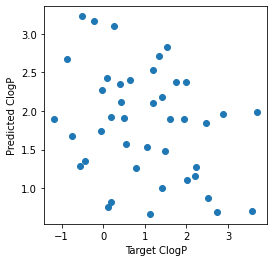

In [32]:
fit = plt.figure(figsize=(4,4))
plt.scatter(valid_targets[i], valid_preds[i])
plt.xlabel('Target ClogP')
plt.ylabel('Predicted ClogP')
plt.show()

Almost no correlation as of first epoch. Let's train a few more epochs and see if the prediciton improves.

In [34]:
scheduler = NoamLR(
    optimizer=optimizer,
    warmup_epochs=[args.warmup_epochs],
    total_epochs=[args.epochs] * args.num_lrs,
    steps_per_epoch=len(train_data) // args.batch_size,
    init_lr=[args.init_lr],
    max_lr=[args.max_lr],
    final_lr=[args.final_lr]
)

loss_func = nn.MSELoss(reduction='none')

optimizer = Adam(params)

metric_func = mean_squared_error


for epoch in tqdm(range(args.epochs)):

    # train 
    model.train()

    loss_sum = iter_count = 0
    n_iter = 0

    for batch in tqdm(train_data_loader, total=len(train_data_loader), leave=False):
        mol_batch, target_batch = batch.batch_graph(), batch.targets()
        mask = torch.Tensor([[x is not None for x in tb] for tb in target_batch])
        targets = torch.Tensor([[0 if x is None else x for x in tb] for tb in target_batch])

        # Run model
        model.zero_grad()
        preds = model(mol_batch)

        # Move tensors to correct device
        mask = mask.to(preds.device)
        targets = targets.to(preds.device)
        class_weights = torch.ones(targets.shape, device=preds.device)

        loss = loss_func(preds, targets) * class_weights * mask
        loss = loss.sum() / mask.sum()

        loss_sum += loss.item()
        iter_count += 1

        loss.backward()

        optimizer.step()

        if isinstance(scheduler, NoamLR):
            scheduler.step()

        n_iter += len(batch)

    # eval

    model.eval()

    preds = []

    for batch in tqdm(val_data_loader, disable=False, leave=False):
        # Prepare batch
        batch: MoleculeDataset
        mol_batch = batch.batch_graph()

        # Make predictions
        with torch.no_grad():
            batch_preds = model(mol_batch)

        batch_preds = batch_preds.data.cpu().numpy()

        # Collect vectors
        batch_preds = batch_preds.tolist()
        preds.extend(batch_preds)

    # valid_preds and valid_targets have shape (num_tasks, data_size)
    num_tasks = 1
    targets = val_data_loader.targets

    valid_preds = [[] for _ in range(num_tasks)]
    valid_targets = [[] for _ in range(num_tasks)]
    for i in range(num_tasks):
        for j in range(len(preds)):
            if targets[j][i] is not None:  # Skip those without targets
                valid_preds[i].append(preds[j][i])
                valid_targets[i].append(targets[j][i])

    result = metric_func(valid_targets[i], valid_preds[i])
    print(epoch, result)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

0 0.5059666700564436


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

1 0.6747574089163861


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

2 0.29365952162247105


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

3 0.2443422001168768


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

4 0.22893787807471938


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

5 0.24693692581926335


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

6 0.18068380381421822


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

7 0.16628313459548472


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

8 0.15646424430563233


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

9 0.14714968670153764


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

10 0.1484021422019028


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

11 0.1497949169195903


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

12 0.1332405691696682


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

13 0.12293908860736892


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

14 0.12480342381848945


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

15 0.12231600820223316


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

16 0.12469534214189118


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

17 0.12742151396520932


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

18 0.10947115821963195


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

19 0.11363330373825292


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

20 0.10276127977714987


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

21 0.10135583119599778


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

22 0.10164295643187546


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

23 0.09673642613524305


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

24 0.09645447176601984


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

25 0.0980465410170695


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

26 0.09245372955020192


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

27 0.08906743111716783


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

28 0.0879800185507161


  0%|          | 0/164 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

29 0.09138532813108272


Over the course of training 30 epochs, the MSE quickly improved and reached to less than 0.1 at the end! Let's take a look at the target vs predicted values. So, we got to this level of prediction without ever specifically wrote code for computing ClogP.

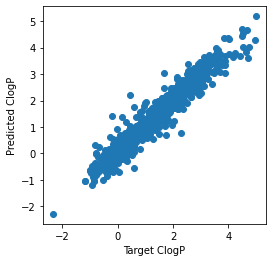

In [35]:
fit = plt.figure(figsize=(4,4))
plt.scatter(valid_targets[i], valid_preds[i])
plt.xlabel('Target ClogP')
plt.ylabel('Predicted ClogP')
plt.show()

# Conclusion

In this post, I have trained a graph neural network that can predict ClogP property. Within 30 epochs, it was able to predict the property pretty accurately in less than 0.1 MSE. Given only very simple features were used in atom and bond features, it was able to "learn" to predict the property fairly quickly.

Now that we have a trained model, a few things I'd like to try:
- compare this model with other traditional model and compare performance
- try different parameters, such as `depth`
- try alternative featurization, i.e., add if bond is rotatable in the bond_features and so on.
- add long-range connection;current network is limited to chemical bonds, but longer range interaction may also be important.